In [6]:
import time
timestamp_start = time.time()

# Training
Train `Doc2Vec` on both the training and the test data building a word → document inverted index. The training data are diverse English data sets.

In [7]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
import pickle
import gzip

TRAINING_FNAME="SemEval-2014_Task-3/data/training/paragraph2sentence.train.input.tsv"
OTHER_TRAINING_FNAMES=[]
TEST_FNAME="SemEval-2014_Task-3/data/test/paragraph2sentence.test.input.tsv"
TEST_GOLD_SCORE_FNAME="SemEval-2014_Task-3/keys/test/paragraph2sentence.test.gs.tsv"
NOTEBOOK_FNAME="untrained_bare"
MODEL_FNAME="untrained"

debug_file = open(NOTEBOOK_FNAME + ".log", 'w')
def debug(message):
    print(message, end='')
    debug_file.write(message)
    debug_file.flush()

buffers = {} # buffer files into RAM
for fname in OTHER_TRAINING_FNAMES:
    debug("Reading %s into RAM..." % fname) # print progress
    buffer = []
    with open(fname) as f:
        for doc in f:
            buffer.append(doc)
    buffers[fname] = buffer
    debug(" DONE\n") # print progress

In [8]:
wnl = WordNetLemmatizer()
inverted_index_serials = {}

def preprocess_document(doc, tag):
    for serial, w in enumerate(simple_preprocess(doc)):
        lemma = wnl.lemmatize(w)
        if lemma not in inverted_index:
            inverted_index[lemma] = {}
        if tag not in inverted_index[lemma]:
            if lemma not in inverted_index_serials:
                inverted_index_serials[lemma] = 0
            inverted_index[lemma][tag] = inverted_index_serials[lemma]
            inverted_index_serials[lemma] = inverted_index_serials[lemma] + 1
        yield lemma
        
class DocumentIterator(object):
    def __init__(self):
        self.epoch_number = 1
    def __iter__(self):
        debug(" Epoch %d: " % self.epoch_number) # print progress
        self.epoch_number = self.epoch_number + 1
        with open(TRAINING_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("training-" + cols[2] + "-paragraph", "training-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])
        doc_number = 1
        for fname in OTHER_TRAINING_FNAMES:
            debug(".") # print progress
            for doc in buffers[fname]:
                tag = str(doc_number)
                doc_number = doc_number + 1
                yield TaggedDocument(words=list(preprocess_document(doc, tag)), tags=[tag])
        with open(TEST_FNAME) as f:
            for row in f:
                cols = row.rstrip().split("\t")
                tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
                yield TaggedDocument(words=list(preprocess_document(cols[0], tags[0])), tags=[tags[0]])
                yield TaggedDocument(words=list(preprocess_document(cols[1], tags[1])), tags=[tags[1]])

try:
    with gzip.open(MODEL_FNAME + ".index", "rb") as f:
        inverted_index = pickle.load(f)
    model = Doc2Vec.load(MODEL_FNAME + ".doc2vec")
except IOError:
    inverted_index = {}
    model = Doc2Vec(DocumentIterator(), dm=1, iter=100, size=100, workers=16)
    model.save(MODEL_FNAME + ".doc2vec") # persist the model
    with gzip.open(MODEL_FNAME + ".index", "wb") as f: # persist the inverted index
        pickle.dump(inverted_index, f, protocol=2)

 Epoch 1:  Epoch 2:  Epoch 3:  Epoch 4:  Epoch 5:  Epoch 6:  Epoch 7:  Epoch 8:  Epoch 9:  Epoch 10:  Epoch 11:  Epoch 12:  Epoch 13:  Epoch 14:  Epoch 15:  Epoch 16:  Epoch 17:  Epoch 18:  Epoch 19:  Epoch 20:  Epoch 21:  Epoch 22:  Epoch 23:  Epoch 24:  Epoch 25:  Epoch 26:  Epoch 27:  Epoch 28:  Epoch 29:  Epoch 30:  Epoch 31:  Epoch 32:  Epoch 33:  Epoch 34:  Epoch 35:  Epoch 36:  Epoch 37:  Epoch 38:  Epoch 39:  Epoch 40:  Epoch 41:  Epoch 42:  Epoch 43:  Epoch 44:  Epoch 45:  Epoch 46:  Epoch 47:  Epoch 48:  Epoch 49:  Epoch 50:  Epoch 51:  Epoch 52:  Epoch 53:  Epoch 54:  Epoch 55:  Epoch 56:  Epoch 57:  Epoch 58:  Epoch 59:  Epoch 60:  Epoch 61:  Epoch 62:  Epoch 63:  Epoch 64:  Epoch 65:  Epoch 66:  Epoch 67:  Epoch 68:  Epoch 69:  Epoch 70:  Epoch 71:  Epoch 72:  Epoch 73:  Epoch 74:  Epoch 75:  Epoch 76:  Epoch 77:  Epoch 78:  Epoch 79:  Epoch 80:  Epoch 81:  Epoch 82:  Epoch 83:  Epoch 84:  Epoch 85:  Epoch 86:  Epoch 87:  Epoch 88:  Epoch 89:  Epoch 90:  Epoch 91:  Epoch 9

# Testing
Compute the cosine similarity of the disambiguated document vectors of the testing paragraph-sentence pairs.

In [9]:
import scipy.spatial
import numpy as np

def cosine_similarity(vec1, vec2): # cosine similarity clamped to [0; 2]
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0
    else:
        return 2.0 - scipy.spatial.distance.cosine(vec1, vec2)

In [10]:
test_similarities = []
with open(TEST_FNAME) as f:
    for row in f:
        cols = row.rstrip().split("\t")
        tags = ("test-" + cols[2] + "-paragraph", "test-" + cols[2] + "-sentence")
        disambiguated_vec1 = model.docvecs[tags[0]]
        disambiguated_vec2 = model.docvecs[tags[1]]
        test_similarities.append(cosine_similarity(disambiguated_vec1, disambiguated_vec2) * 2.0)

Compare the similarities with the gold score.

<IPython.core.display.Javascript object>


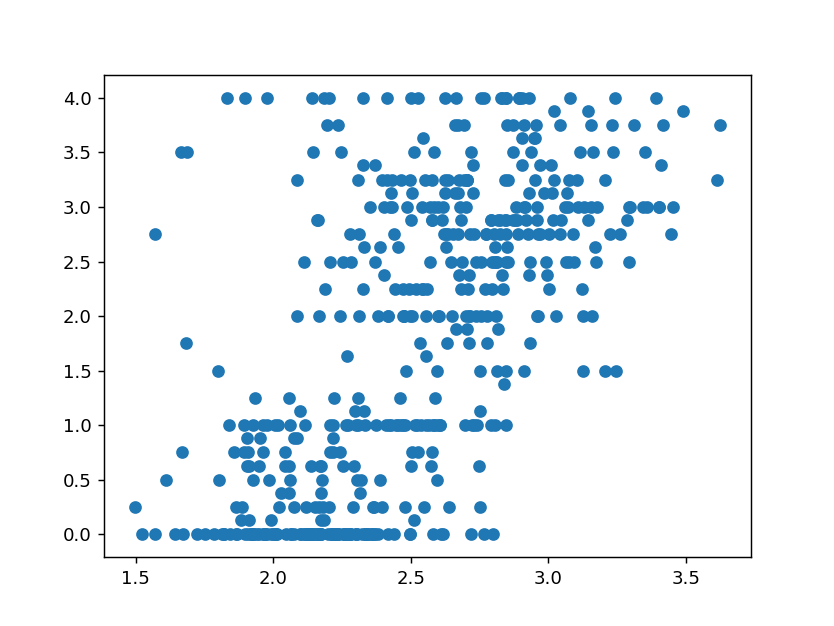

Pearson's correlation coefficient: 0.623310


In [11]:
%matplotlib notebook
import scipy.stats
import matplotlib.pyplot as plt

test_gold_similarities = []
with open(TEST_GOLD_SCORE_FNAME) as f:
    for line in f:
        test_gold_similarities.append(float(line))

plt.scatter(test_similarities, test_gold_similarities)
plt.show()
debug("Pearson's correlation coefficient: %f\n" % scipy.stats.pearsonr(test_similarities, test_gold_similarities)[0])

In [12]:
timestamp_end = time.time()
debug("Time elapsed: %d seconds\n" % (timestamp_end - timestamp_start))

Time elapsed: 103 seconds
